In [1]:
import tensorflow as tf
import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('Tensorflow\\workspace\\models\\my_ssd_mobnet\\pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)


# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('Tensorflow\\workspace\\models\\my_ssd_mobnet\\ckpt-11').expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
category_index = label_map_util.create_category_index_from_labelmap('Tensorflow\\workspace\\annotations\\label_map.pbtxt')

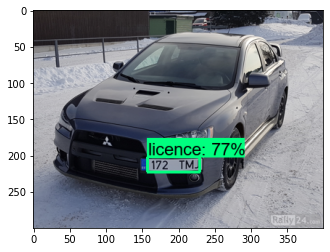

In [6]:
img = cv2.imread('Tensorflow\\workspace\\images\\test\\Cars416.png')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.7,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
import easyocr

In [ ]:
detection_threshold=0.6

In [ ]:
region_threshold = 0.25

In [ ]:
def filter_text(region,ocr_result,region_threshold):
    rectangle_size=region.shape[0]*region.shape[1]
    
    plate=[]
    
    for result in ocr_result:
        length=np.sum(np.subtract(result[0][1],result[0][0]))
        height=np.sum(np.subtract(result[0][2],result[0][1]))
        
        if length*height/rectangle_size>region_threshold:
            plate.append(result[1])
        

    return plate
    

In [ ]:
def ocr_it(image,detections,detection_threshold,region_threshold):
    scores=list(filter(lambda x:x>detection_threshold,detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]
    
    #dimensions of complete image
    width = image.shape[1]
    height = image.shape[0]
    
    #ROI filtering and OCR
    for idx,box in enumerate(boxes):
        roi=box*[height,width,height,width]
        region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader=easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)

        text=filter_text(region,ocr_result,region_threshold)

        plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))
        print(text)
        return text,region

In [ ]:
text,region=ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)

In [ ]:
import csv
import uuid

In [ ]:
'{}.jpg'.format(uuid.uuid1())

In [ ]:
def save_result(text,region,csv_filename,folder_path):
    img_name='{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path,img_name),region)
    
    with open(csv_filename,mode='a',newline='') as f:
        csv_writer=csv.writer(f,delimiter=',',quotechar='"',quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name,text])

In [ ]:
save_result(text,region,'detection_results.csv','Detection_Images')

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try:
        text, region=ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)
        save_result(text,region,'detection_live_results.csv','Detection_Live_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break